# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell.
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions.

# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (35 points)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

##  What you need to do
For this task, you are required to build a fully connect feed-forward ANN model
for a classification problem.

For the given data, you need do proper data preprocessing, data analysis,
design the ANN model, then fine-tune your model architecture.

For evaluating your model, do $ 80/20 $ train test split.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Identify the appropriate classification approach for a given problem. 20%
- Apply ANNs to solve a classification problem (basic training, validation, testing -- without fine tuning). 50%
- Fine-tune to determine the optimal model architecture. 20%


### Data
You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`) 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - location
 - sites
 - time
 - date

After training, evaluate you model by print [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
on your test set. 

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

``` 
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# read data from file
data = pd.read_csv("task 1.csv")

# divide data and drop innecessary columns
X = data.drop(columns = ['index', 'user_id', 'sites'])
y = data['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [ ]:
# impute missed values
imputer = SimpleImputer(strategy='constant', fill_value='missing')
imputer.fit(X_train)
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [ ]:
# one-hot encoding function
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # Create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, columns=encoder.get_feature_names_out(features_name))
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

# convert time column to seconds
def time_to_seconds(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [ ]:
# encode browser, os, locale, location columns as they are categorical features
encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['browser', 'os', 'locale', 'location']
encoder.fit(X_train[f_names])
X_train = ohe_new_features(X_train, f_names, encoder)
X_test = ohe_new_features(X_test, f_names, encoder)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# convert time and date
X_train['time'] = X_train['time'].apply(time_to_seconds)
X_test['time'] = X_test['time'].apply(time_to_seconds)
X_train['date'] = pd.to_datetime(X_train['date']).astype(int) // 10**9 // 86400
X_test['date'] = pd.to_datetime(X_test['date']).astype(int) // 10**9 // 86400

# scale data
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# edit y to define user_id, which is equal to 0, as 0 and all other ids as 1
y_train_binary = np.where(y_train == 0, 1, 0)
y_test_binary = np.where(y_test == 0, 1, 0)

# convert data to numpy
X_train = X_train.to_numpy().astype('float32')
X_test = X_test.to_numpy().astype('float32')
y_train_binary = y_train_binary.astype('float32')
y_test_binary = y_test_binary.astype('float32')

In [ ]:
# f1-score for model`s metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * ((precision * recall) / (precision + recall + 1e-7))
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [ ]:
# function for model creation
def make_model(output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

  model.compile(
      optimizer=Adam(learning_rate=1e-3),
      loss='binary_crossentropy',
      metrics=[metrics.BinaryAccuracy(), F1Score(), metrics.AUC()])

  return model

In [ ]:
# model creation, fitting and predicting
model = make_model()
early_stopping = EarlyStopping(monitor='val_f1_score', patience=10, mode='max', restore_best_weights=True)
history = model.fit(X_train, y_train_binary, validation_split=0.2, epochs=30, batch_size=64, callbacks=[early_stopping])
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

Epoch 1/30
194/204 [===========================>..] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9773 - f1_score: 0.0408 - auc_4: 0.8637

/usr/local/lib/python3.9/dist-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


204/204 [==============================] - 5s 10ms/step - loss: 0.1050 - binary_accuracy: 0.9776 - f1_score: 0.0757 - auc_4: 0.8772 - val_loss: 0.0191 - val_binary_accuracy: 0.9917 - val_f1_score: 0.7158 - val_auc_4: 0.9991
Epoch 2/30
204/204 [==============================] - 1s 7ms/step - loss: 0.0100 - binary_accuracy: 0.9980 - f1_score: 0.9506 - auc_4: 0.9996 - val_loss: 0.0084 - val_binary_accuracy: 0.9975 - val_f1_score: 0.9344 - val_auc_4: 0.9993
Epoch 3/30
204/204 [==============================] - 1s 4ms/step - loss: 0.0048 - binary_accuracy: 0.9990 - f1_score: 0.9759 - auc_4: 0.9997 - val_loss: 0.0081 - val_binary_accuracy: 0.9975 - val_f1_score: 0.9344 - val_auc_4: 0.9993
Epoch 4/30
204/204 [==============================] - 1s 4ms/step - loss: 0.0040 - binary_accuracy: 0.9990 - f1_score: 0.9759 - auc_4: 0.9997 - val_loss: 0.0077 - val_binary_accuracy: 0.9975 - val_f1_score: 0.9344 - val_auc_4: 0.9994
Epoch 5/30
204/204 [==============================] - 1s 4ms/step - loss: 

In [ ]:
# output of classification report and confusion matrix for checking results
print("Classification report:\n", classification_report(y_test_binary, y_pred_classes))
print("Confusion matrix:\n", confusion_matrix(y_test_binary, y_pred_classes))

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4001
         1.0       0.90      1.00      0.95        80

    accuracy                           1.00      4081
   macro avg       0.95      1.00      0.97      4081
weighted avg       1.00      1.00      1.00      4081

Confusion matrix:
 [[3992    9]
 [   0   80]]


In [ ]:
# load data for verification
data_verify = pd.read_csv("/content/task_1_verify.csv")
X_verify = data_verify.drop(columns=['sites'])
X_verify = pd.DataFrame(imputer.transform(X_verify), columns=X_verify.columns)

# the same data preprocessing as for train and test data
X_verify = ohe_new_features(X_verify, f_names, encoder)
X_verify['time'] = X_verify['time'].apply(time_to_seconds)
X_verify['date'] = pd.to_datetime(X_verify['date']).astype(int) // 10**9 // 86400
X_verify = pd.DataFrame(scaler.transform(X_verify), columns=X_verify.columns)
X_verify = X_verify.to_numpy().astype('float32')

# prediction on X_verify
y_pred_verify = model.predict(X_verify)
y_pred_verify_classes = (y_pred_verify > 0.5).astype(int).flatten()

# print 0 if a user is not Waldo, else print 1
idx = 0
for i in y_pred_verify_classes:
  print(f'{idx}: {i}')
  idx += 1

2/2 [==============================] - 0s 5ms/step
0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 1
32: 1
33: 1
34: 1
35: 1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Questions
1. Did you find any usefull insights from your data analysis?
    - *I understood that information about sites is unnecessary for creation of a good model. The values of sites are rarely repeated and are diffficult for encoding, so this column can be deleted. It makes the model simpler and more understandble.*
2. What preprocessing techniques did you use? Why?
    - *I used imputing as some values were missed. One-hot encoding was necessary for categorical features: browser, os, locale, location. Time was converted to seconds, date was converted to integer. Then I applied min-max normalization to scale the data as target values had the same scale.*
3. Describe the fine-tuning process and how you reached your model architecture.
    - *During fine-tuning I found that there is no need to have a lot of layers and huge amount of the neurons inside the network. According to the best practices, I took ReLU as activation function for each hidden layer. Also I decided to use Adam optimizer, as it is preferable in the modern neural networks. As a result, the model has the following architecture: one input layer, 2 hidden layers (with 64 neurons in each) and 1 output layer. Hidden layers have the "relu" activation function, output layer - "sigmoid". Adam optimizer with learning rate 1e-4 is used.*
4. Which metric did you try to optimize for this task? Why?
    - *First of all, I tried to optimize only f1-score as dataset was imbalanced. Nevertheless, for model compilation I used Binary accuracy, f1-score and AUC. It gives better result than just use of f1-score. BinaryAccuracy measures the percentage of correctly predicted binary labels. AUC enables to measure ability to distinguish between positive and negative samples, which is useful in imbalanced dataset. So, this combination is suitable for optimization of the given task.*

# Task 2: Fingerprint Recognition (50 points)
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

## What you need to do

For this task, you will be doing image classification:
- Build a CNN model for image classification.
- Estimate the speed of inference of your model

For the given data, you need to do proper data preprocessing, augmentation, and data loaders.

Then fine-tune your model architecture to achieve the highest accuracy.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Use literature (any paper on the use of CNN for fingerprinting and cite it) to choose an architecture. 10%
- Apply CNNs to solve an image classification problem (basic training, validation, testing -- without fine tuning). 40%
- Fine-tune your model to improve performance. 20%
- Use of data augmentation to improve model’s performance. 20%
- Explore beyond data augmentation find techniques to improve model’s performance and use them. 15%(bonus)


### Data
You will be working with the data in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# extract files from zip
def extract_zip(file, target_dir):
    with zipfile.ZipFile(file, "r") as zip_ref:
        zip_ref.extractall(target_dir)

In [ ]:
# extract train and test datasets
extract_zip("task 2.zip", "task_2")
extract_zip("task_2/train.zip", "task_2/train")
extract_zip("task_2/test.zip", "task_2/test")

In [ ]:
# class for dataset with images convertion
class FingerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["label"]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# function for data loading
def load_data(data_dir):
    data = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        file_extension = Path(img_path).suffix.lower()
        label = int(img_name.split("_")[1].split(".")[0])
        data.append([img_path, label])

    return pd.DataFrame(data, columns=["path", "label"])

In [ ]:
# load data and split it
train_data_dir = "task_2/train/train"
test_data_dir = "task_2/test/content/test"
train_df = load_data(train_data_dir)
test_df = load_data(test_data_dir)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

In [ ]:
# define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val_test = transforms.Compose([
    transforms.Resize((64, 64)),
#    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# create datasets with usage of transforms
train_dataset = FingerDataset(train_df, transform=transform)
val_dataset = FingerDataset(val_df, transform=transform_val_test)
test_dataset = FingerDataset(test_df, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# class with the final chosen model of CNN
class FingerClassifier(nn.Module):
    def __init__(self):
        super(FingerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    early_stopping_counter = 0 # own early stopping as torch does not have it
    best_val_loss = float('inf')

    for epoch in range(num_epochs): # training cycle
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss/len(train_loader)
        epoch_val_loss = val_loss/len(val_loader)
        val_accuracy = correct/total*100

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # check for early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 5:
                print(f"Early stopping triggered after 5 epochs of no improvement.")
                break

In [ ]:
# create and train model
model = FingerClassifier()
num_epochs = 100
learning_rate = 0.001
train_model(model, train_loader, val_loader, num_epochs, learning_rate)



Epoch 1/100, Training Loss: 1.6974, Validation Loss: 1.3386, Validation Accuracy: 52.56%
Epoch 2/100, Training Loss: 1.2684, Validation Loss: 1.1300, Validation Accuracy: 58.41%
Epoch 3/100, Training Loss: 1.1258, Validation Loss: 0.9994, Validation Accuracy: 63.97%
Epoch 4/100, Training Loss: 1.0292, Validation Loss: 0.9599, Validation Accuracy: 65.23%
Epoch 5/100, Training Loss: 0.9451, Validation Loss: 0.8960, Validation Accuracy: 68.32%
Epoch 6/100, Training Loss: 0.8803, Validation Loss: 0.8421, Validation Accuracy: 69.77%
Epoch 7/100, Training Loss: 0.8047, Validation Loss: 0.7350, Validation Accuracy: 72.88%
Epoch 8/100, Training Loss: 0.7367, Validation Loss: 0.7182, Validation Accuracy: 73.91%
Epoch 9/100, Training Loss: 0.6825, Validation Loss: 0.6310, Validation Accuracy: 77.08%
Epoch 10/100, Training Loss: 0.6167, Validation Loss: 0.5984, Validation Accuracy: 78.73%
Epoch 11/100, Training Loss: 0.5771, Validation Loss: 0.5111, Validation Accuracy: 82.38%
Epoch 12/100, Train

In [ ]:
# test the model
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            test_output = model(images)
            _, pred_y = torch.max(test_output, 1)
            total += labels.size(0)
            correct += (pred_y == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}%')

test(model, test_loader)

Test Accuracy of the model on the 14272 test images: 89.17%


In [ ]:
import time

# function to measure inference speed
def measure_inference_speed(model, dataloader, num_samples=100):
    model.eval()
    total_time = 0
    samples_counted = 0

    with torch.no_grad():
        for images, _ in dataloader:
            start_time = time.time()
            _ = model(images)
            end_time = time.time()
            total_time += end_time - start_time
            samples_counted += images.size(0)

            if samples_counted >= num_samples:
                break

    avg_inference_time = total_time / samples_counted
    print(f"Average inference time per sample: {avg_inference_time:.6f} seconds")

measure_inference_speed(model, val_loader)


Average inference time per sample: 0.004264 seconds


### Questions
1. What preprocessing techniques did you use? Why?
    - *The preprocessing techniques used include resizing the images and normalizing the pixel values. Resizing the images to a consistent size (64x64) is necessary because the input to a CNN must have a fixed size. Normalizing the pixel values is performed by converting the pixel values from a range of [0, 255] to a range of [-1, 1]. This normalization step helps improve the convergence of the model during training because it ensures that the input values have a consistent scale.*
2. What data augmentation techniques did you use?
    - *The data augmentation techniques used in the provided code include random rotation. This technique is applied to increase the diversity of the training dataset and help the model generalize better to unseen data.*
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *I used "CNNAI: A Convolution Neural Network-Based Latent Fingerprint Matching Using the Combination of Nearest Neighbor Arrangement Indexing" by Uttam U. Deshpande et others to choose architecture. It looked like this: an input layer, followed by six convolutional layers, then maxpooling, flatten, and finally two dense layers.The activation function used in the convolutional layers was ReLU. During fine-tuning, I understood that number of convolution layers can be decreased. Also, the batch size in the article was equal to 100. I used it too. After all of this steps the accurasy was equal to 0.9. To improve perfomance I changed model with usage of dropout and batch normalization levels. As a result my final CNN model has such structure: an input layer followed by three convolutional layers, a batch normalization layer to improve the training process and stabilize the learning, a max-pooling layer, which is applied to reduce the spatial dimensions of the feature maps, a dense layer, which takes the flattened output of the previous pooling layer, a dropout layer, which is applied to prevent overfitting and improve generalization, a dense layer with 10 neurons, which serves as the output layer for the 10 different finger classes.
The activation function used in the convolutional and the first fully connected layers is ReLU, while the output layer uses a softmax activation function for multi-class classification.*
4. What techniques did you use to improve model’s performance other than data augmentation
    - *In addition to data augmentation, the following techniques were used to improve the model's performance:*

        a) Deeper architecture: Increasing the depth of the CNN model can help it learn more complex features and patterns from the input images, potentially leading to better performance.

    b) Dropout: Dropout layer was added to the model to improve its generalization by preventing overfitting. Dropout randomly sets some neuron activations to zero during training, forcing the model to rely on multiple paths for processing the input data.

# Task 3: Credit approval (15 points)

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance. 

## What you need to do

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Learning Objectives

- Apply DTs, and RFs to solve a classification problem (basic training, validation, testing. 50%
- Fine-tune to determine the optimal model architecture. 20%
- Evaluate and compare the performance of different models. 10%
- Visualise the models. 20%


### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn import tree

In [ ]:
# load dataset
dataset = pd.read_csv('loan_data.csv')
dataset.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [ ]:
# split dataset 
X = dataset.drop(columns = ['credit.policy'])
y = dataset['credit.policy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [ ]:
# impute missed values
imputer = SimpleImputer(strategy='constant', fill_value='missing')
imputer.fit(X_train)
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [ ]:
# one-hot encoding function
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # Create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, columns=encoder.get_feature_names_out(features_name))
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

In [ ]:
# encode purpuse column 
encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['purpose']
encoder.fit(X_train[f_names])
X_train = ohe_new_features(X_train, f_names, encoder)
X_test = ohe_new_features(X_test, f_names, encoder)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# tuning DT
parameters_tree = {
    "dec_tree__max_depth": [8, 10, 12],
    "dec_tree__criterion": ['gini', 'entropy', 'log_loss'],
}

tuning_tree = DecisionTreeClassifier()

pipe = Pipeline(steps=[('dec_tree', tuning_tree)])

clf_GS = GridSearchCV(pipe, parameters_tree)
clf_GS.fit(X_train, y_train)

best_criterion_tree = clf_GS.best_estimator_.get_params()['dec_tree__criterion']
best_max_depth_tree = clf_GS.best_estimator_.get_params()['dec_tree__max_depth']

print(f"Best criterion for decision tree: {best_criterion_tree}")
print(f"Best max depth value for decision tree: {best_max_depth_tree}")

Best criterion for decision tree: log_loss
Best max depth value for decision tree: 12


In [ ]:
# create DT with the best parameters
dec_tree = DecisionTreeClassifier(max_depth=best_max_depth_tree, criterion=best_criterion_tree, random_state=0)
dec_tree.fit(X_train, y_train)

dec_tree_score = dec_tree.score(X_test, y_test)
print(f"DecisionTreeClassifier score: {dec_tree_score}")

In [ ]:
parameters_forest = {
    "clf__max_depth": [8, 10, 12, 20, 35],
    "clf__criterion": ['gini', 'entropy', 'log_loss'],
    "clf__n_estimators": [50, 100, 200, 300]
}

In [ ]:
# tuning RF
random_forest_tuning = RandomForestClassifier()
pipe = Pipeline(steps=[('clf', random_forest_tuning)])

clf_GS = GridSearchCV(pipe, parameters_forest)
clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy', 'log_loss'],
                         'clf__max_depth': [8, 10, 12, 20, 35],
                         'clf__n_estimators': [50, 100, 200, 300]})

In [ ]:
best_criterion_forest = clf_GS.best_estimator_.get_params()['clf__criterion']
best_max_depth_forest = clf_GS.best_estimator_.get_params()['clf__max_depth']
best_n_estimators_forest = clf_GS.best_estimator_.get_params()['clf__n_estimators']

print(f"Best criterion for random forest: {best_criterion_forest}")
print(f"Best max depth value for random forest: {best_max_depth_forest}")
print(f"Best n estimators value: {best_n_estimators_forest}")

Best criterion for random forest: log_loss
Best max depth value for random forest: 35
Best n estimators value: 300


In [ ]:
# create RF with the best parameters
random_forest = RandomForestClassifier(criterion=best_criterion_forest, max_depth=best_max_depth_forest, n_estimators=best_n_estimators_forest, random_state=0)
random_forest = random_forest.fit(X_train, y_train)

forest_score = random_forest.score(X_test, y_test)
print(f"RandomForestClassifier score: {forest_score}")

RandomForestClassifier score: 0.9874739039665971


In [ ]:
# function to plot trees
def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=dec_tree.feature_names_in_,
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

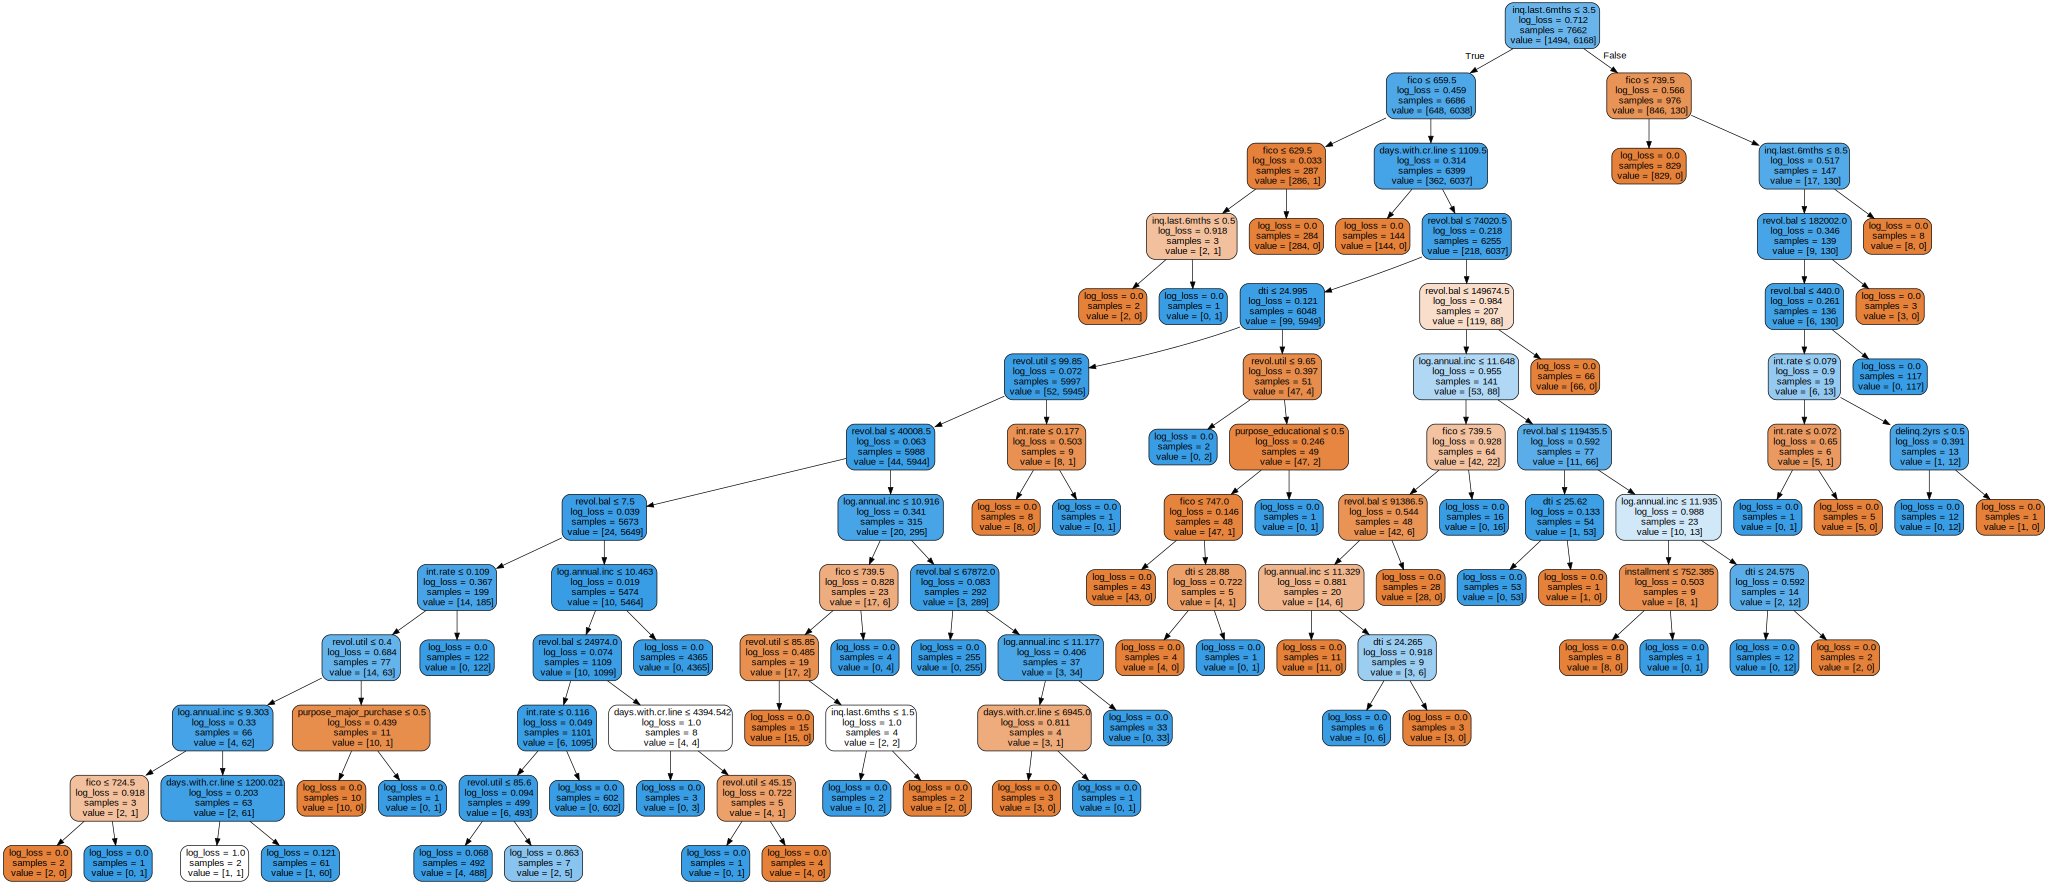

In [ ]:
plot_tree(dec_tree)

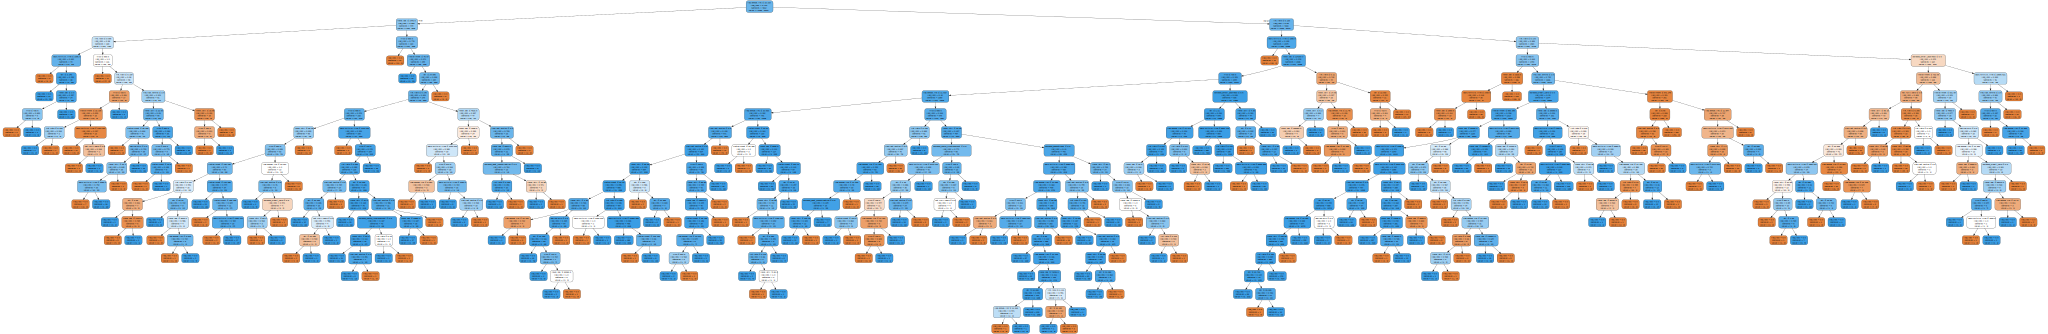

In [ ]:
plot_tree(random_forest.estimators_[0])

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Perfomance of DT and RF is approximately the same. I think that the main reason for it is the given stable data. So, low bias is preferable and, as a result, DT even slightly better for this task.*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *After fine-tuning the decision tree's smaller max depth (12) compared to the random forest's max depth (35) suggests that the single decision tree requires a shallower depth to prevent overfitting. In contrast, the random forest can afford to have deeper individual trees because the ensemble averaging helps to counteract the overfitting risk.*
3. What is ensemble learning? What are its pros and cons?
    - *Ensemble learning is a technique that combines multiple ML models into one predictive model to improve prediction accuracy, reduce overfitting, and enhance stability. It involves methods like bagging, boosting, and stacking.*

          Pros:

          * Improved accuracy
          * Reduced overfitting
          * Better generalization
          * Enhanced stability
          Cons:

          * Increased complexity
          * Higher computational cost
          * Diminished interpretability
          * Risk of overfitting with improper use
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Boosting methods:*

          * AdaBoost (Adaptive Boosting): It trains multiple weak learners sequentially, where each learner corrects the errors made by its predecessor. The final prediction is a weighted combination of the weak learners.
          * Gradient Boosting: It also trains weak learners sequentially, but optimizes the loss function gradient. It builds an additive model by minimizing the residual errors using gradient descent.
    - *Bagging methods*:

          * Hard-voting: This approach takes the most frequent answer (or majority vote) among the weak learners as the final prediction. Each learner's vote is equally weighted, and the class with the highest vote count is chosen.
          * Soft-voting: In this approach, the predicted class probabilities for each weak learner are averaged, and the class with the highest average probability is selected as the final prediction. This method gives more weight to highly confident predictions, which can be beneficial when the weak learners have varying levels of accuracy or confidence in their predictions.
  Random Forest falls under the category of bagging methods, as it trains multiple decision trees on random subsets of the data (with replacement) and combines their predictions using majority voting (hard-voting) or averaging class probabilities (soft-voting).
